## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import joblib
from dotenv import load_dotenv
import html
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset

from langchain.docstore.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS


In [2]:
# Load OpenAI API from .env file
load_dotenv(dotenv_path='./api.env') # Change this to your .env file
print(f"API key loaded: {os.getenv('OPENAI_API_KEY')[:10]}...")

API key loaded: sk-proj-Hw...


## Prepare the ADHD documents from the `Drugscom_reviews` dataset

* The drugscom_reviews dataset is a collection of patient-written reviews for various prescription drugs, originally scraped from Drugs.com website. 

* Each entry contains the following fields:

    1. drugName: Name of the drug being reviewed (e.g. "Aspirin")

    2. condition: Medical condition the drug was used to treat (e.g. "Pain")

    3. review: Free-text review written by the patient   

    4. rating: Numerical rating from 1 (worst) to 10 (best) 

    5. date: Date the review was posted 
    
    6. usefulCount: Number of users who marked the review as helpful


In [3]:
# Load the drugcom reviews dataset from hugging face
dataset = load_dataset("Zakia/drugscom_reviews")

# View data size
print(f"Train: {len(dataset['train'])} samples")
print(f"Test: {len(dataset['test'])} samples")

Train: 161297 samples
Test: 53766 samples


In [4]:
# View a slice of the dataset
dataset['train'][0]

{'Unnamed: 0': 206461,
 'drugName': 'Valsartan',
 'condition': 'Left Ventricular Dysfunction',
 'review': '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
 'rating': 9.0,
 'date': 'May 20, 2012',
 'usefulCount': 27}

Total number of reviews: 215063
Unique drug names: 3671
Unique conditions = 917


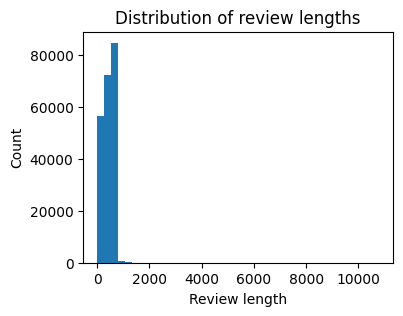

In [5]:
# Combine train/test data
reviews = dataset['train']['review'] + dataset['test']['review']
conditions = dataset['train']['condition'] + dataset['test']['condition']
drug_names = dataset['train']['drugName'] + dataset['test']['drugName']

# Statistics of the drugscom_review dataset
print(f"Total number of reviews: {len(reviews)}")
print(f"Unique drug names: {len(set(drug_names))}")
print(f"Unique conditions = {len(set(conditions))}")

# View distribution of review lengths
lengths = [len(item) for item in reviews]
plt.figure(figsize=(4,3))
plt.hist(lengths, bins=40);
plt.xlabel('Review length'); 
plt.ylabel('Count');
plt.title('Distribution of review lengths');



Number of ADHD review = 4497
Number of unique ADHD drugs = 58


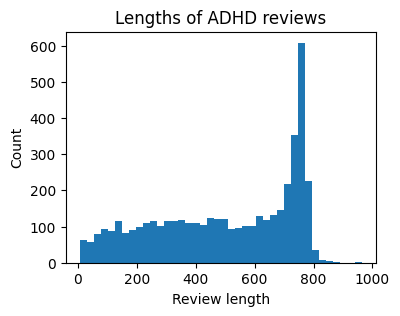

In [6]:
# Statistics of only ADHD data
# Select only reviews with less than 1000 characters
assert 'ADHD' in conditions
adhd_reviews, adhd_drug_names = [], []
for i,condition in enumerate(conditions):
    if condition == 'ADHD' and len(reviews[i]) < 1000:
        adhd_reviews.append(reviews[i])
        adhd_drug_names.append(drug_names[i])
print(f"Number of ADHD review = {len(adhd_reviews)}")
print(f"Number of unique ADHD drugs = {len(set(adhd_drug_names))}")
lengths2 = [len(item) for item in adhd_reviews]
plt.figure(figsize=(4,3))
plt.hist(lengths2, bins=40);
plt.xlabel('Review length'); 
plt.ylabel('Count');
plt.title('Lengths of ADHD reviews');

In [7]:
# Create documents from the ADHD reviews with LangChain

documents = []
for split in ['train', 'test']:
    for item in dataset[split]:
        # Only use ADHD reviews
        condition = item.get("condition", "")
        if condition != 'ADHD':
            continue
        # Get review text as page content
        text = item['review'].replace('\n', '').replace('\r', '') # Each document should be a single line
        text = html.unescape(text) # Unescape HTML characters, e.g. I&#039;m => I'm
        text = f"Review of {item['drugName']}: {text}" # Add drug name to document
        metadata = {
                "drug": item.get("drugName", ""),
                "rating": item.get("rating", -1),
                "date": item.get("date", ""),
                "usefulCount": item.get("usefulCount", 0),
        }
        doc = Document(page_content=text, metadata=metadata)
        documents.append(doc)
        
print(f"Number of documents = {len(documents)}")
print(documents[0])

Number of documents = 4509
page_content='Review of Guanfacine: "My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. We have tried many different medications and so far this is the most effective."' metadata={'drug': 'Guanfacine', 'rating': 8.0, 'date': 'April 27, 2010', 'usefulCount': 192}


In [12]:
# View documents
documents[0]

Document(metadata={'drug': 'Guanfacine', 'rating': 8.0, 'date': 'April 27, 2010', 'usefulCount': 192}, page_content='Review of Guanfacine: "My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. We have tried many different medications and so far this is the most effective."')

In [8]:
# Clear memory
del (dataset, reviews, conditions, drug_names, adhd_reviews, adhd_drug_names)

In [10]:
# Save documents as text file and joblib
with open('data/adhd_drug_reviews.txt', 'w') as f:
    for doc in documents:
        if not doc.page_content.startswith('Review of '):
            print(doc.page_content)
        f.write(f"{doc.page_content}\n")

joblib.dump(documents, 'data/adhd_drug_reviews.pkl')

['adhd_drug_reviews_document.pkl']

## Generate question/answer pairs for evaluation

* We'll generate 50 questions to evaluate the performance of our RAG approach.

* We'll use a powerful LLM (GPT-4o) with full access to the drug review dataset as context to answer these questions. This performance will serve as the ground truth.

* Then we'll compare the performance of our RAG approach, using a lighter-weight LLM (GPT-3.5) without access to the full drug review dataset, against that ground truth.

In [ ]:
# Prompt to generate 50 evaluation questions
# Pass this prompt to GPT-4o

with open('data/adhd_drug_reviews.txt', 'r') as f:
    document_text = f.read()

system_prompt = """
You are a helpful assistant that generates high-quality, information-rich questions based on user-provided documents. 
Your goal is to produce questions that real people might ask when evaluating experiences with medical treatments, especially from a patient's perspective.
"""

user_prompt = f"""
Based on the patient review document below, generate 50 well-formed questions that could be asked by patients who are using ADHD medications and are looking for insights from other patients. 
Each question must be answerable using information found directly in the document. Do not invent or infer beyond what is present.
Focus on detailed, open-ended questions that cannot be answered with yes or no. 
Prioritize questions that explore personal experiences, symptom changes, side effects, drug effectiveness, and quality-of-life impacts. 
Include some comparative questions that examine differences in effectiveness or side effects between two or more drugs. 
Make the questions useful for someone researching medication options based on lived experience.

--- BEGIN DOCUMENT ---
{document_text}
--- END DOCUMENT ---
"""


In [ ]:
# Prompt to generate answers for each of the 50 questions
# Pass this prompt to GPT-4o

questions = pd.read_csv('data/test_data', index_col=None)['QUESTIONS'].values
question = questions[0] # Selection, do this for all questions

system_prompt = """
You are a helpful assistant that provides concise, evidence-based answers to user questions based on patient-provided documents.
Your goal is to summarize real experiences with medical treatments as described in the text, without inventing or extrapolating beyond what is presented.

"""

user_prompt = f"""
Based on the patient review document attached, answer the following question using only information found directly in the document. 
Your answer should be a few sentences and be concise.
Avoid speculation, generalizations, or added interpretation. Focus only on what patients actually report.

Here is an example of how you should answer:

Question: What changes typically occur in a child’s mood or energy after starting Intuniv?
Answer: After starting Intuniv, children often experience increased calmness, reduced impulsivity, and better sleep. However, some also show decreased energy, fatigue, irritability, or emotional flatness. Responses vary depending on the dosage and individual sensitivity.

Use this style in your own answers.

Question: {question}

--- BEGIN DOCUMENT ---
{document_text}
--- END DOCUMENT ---
"""
